In [1]:
from keras.applications import VGG16

In [3]:
conv_base=VGG16(weights="imagenet",
                include_top=False,
                input_shape=(150,150,3)
               )

58892288/58889256 [==============================] - 97s 2us/step


In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [6]:
#ahora congelamos el modelo
conv_base.trainable=False

In [8]:
#creamos un nuevo modelo
import tensorflow as tf
def build_model():
    model=tf.keras.Sequential()
    model.add(conv_base)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512,activation="relu"))
    model.add(tf.keras.layers.Dense(1,activation="sigmoid"))
    #compilacion del modelo
    model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
                  metrics=["accuracy"]
                 )
    return model

In [9]:
build_model()

In [10]:
import os
#configuracion de rutas de acceso
path_images=r"C:\Users\JOHAN\Downloads\dogs-vs-cats_dest"

train_images=os.path.join(path_images,"train")
test_images=os.path.join(path_images,"test")
val_images=os.path.join(path_images,"val")

In [12]:
#configuracion del generador de imagenes
from keras.preprocessing.image import ImageDataGenerator


In [14]:
train_datagen=ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

In [22]:
val_datagen=ImageDataGenerator(rescale=1.0/255)

In [23]:
#aplicacion de configuracion
batch_size=20
train_generator=train_datagen.flow_from_directory(
    train_images,
    target_size=(150,150),
    batch_size=batch_size,
    class_mode="binary"
    )

validation_generator=val_datagen.flow_from_directory(
    val_images,
    target_size=(150,150),
    batch_size=batch_size,
    class_mode="binary"   
    )
#validacion en los datos de testeo
test_generator=ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    test_images,
    target_size=(150,150),
    batch_size=batch_size,
    class_mode="binary"   
    )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
#creacion y entrenamiento del modelo

model_conv=build_model()

history=model_conv.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//batch_size,
    
    epochs=5 #debido a que uso un CPU
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
100/100 [==============================] - 244s 2s/step - loss: 0.5552 - accuracy: 0.7190 - val_loss: 0.4208 - val_accuracy: 0.8120
Epoch 2/5
100/100 [==============================] - 247s 2s/step - loss: 0.4564 - accuracy: 0.7995 - val_loss: 0.3523 - val_accuracy: 0.8590
Epoch 3/5
100/100 [==============================] - 245s 2s/step - loss: 0.4107 - accuracy: 0.8135 - val_loss: 0.3056 - val_accuracy: 0.8800
Epoch 4/5
100/100 [==============================] - 243s 2s/step - loss: 0.3797 - accuracy: 0.8400 - val_loss: 0.2913 - val_accuracy: 0.8810
Epoch 5/5
100/100 [==============================] - 245s 2s/step - loss: 0.3823 - accuracy: 0.8275 - val_loss: 0.2859 - val_accuracy: 0.8860


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
#mostramos los resultados
def plot_loss(history):
    epochs=range(1,len(history["loss"])+1)
    
    plt.plot(epochs,history["loss"],"bo-",label="train")
    plt.plot(epochs,history["val_loss"],"ro-",label="val")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()
    
def plot_metrics(history):
    epochs=range(1,len(history["accuracy"])+1)
    
    plt.plot(epochs,history["accuracy"],"bo-",label="train")
    plt.plot(epochs,history["val_accuracy"],"ro-",label="val")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

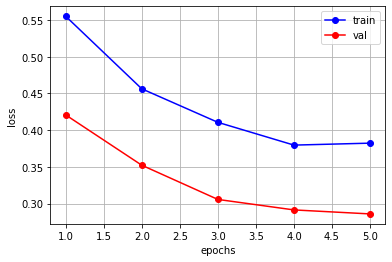

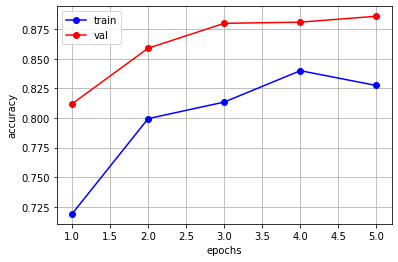

In [27]:
plot_loss(history.history)
plot_metrics(history.history)

In [31]:
model_conv.evaluate(test_generator,steps=50)

50/50 [==============================] - 77s 2s/step - loss: 0.3020 - accuracy: 0.8690


[0.3020208775997162, 0.8690000176429749]

In [32]:
#como los resultados se ven ruidosos aplicaremos un suavizadode curvasa
#con las medias moviles exponenciales

def smooth_curve(points,factor=0.8):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [37]:
hst={
    "accuracy":smooth_curve(history.history["accuracy"]),
    "val_accuracy":smooth_curve(history.history["val_accuracy"]),
    "loss":smooth_curve(history.history["loss"]),
    "val_loss":smooth_curve(history.history["val_loss"]),
}

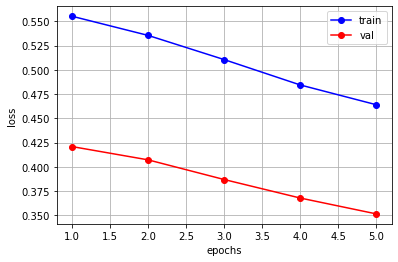

In [38]:
plot_loss(hst)

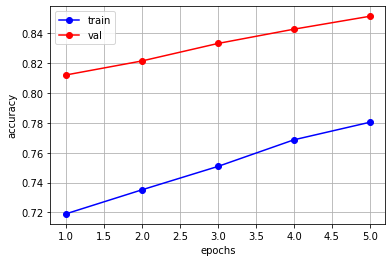

In [39]:
plot_metrics(hst)

In [40]:
#guardamos el modelo de 5 epochs
model_conv.save("cats_and_dogs_classifier.h5")

In [41]:
#cargamos el modelo
from keras.models import load_model
model=load_model("cats_and_dogs_classifier.h5")
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [42]:
model.input

<tf.Tensor 'vgg16_input_4:0' shape=(None, 150, 150, 3) dtype=float32>